In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('lending_club_loan_two.csv')

<AxesSubplot: xlabel='loan_status', ylabel='count'>

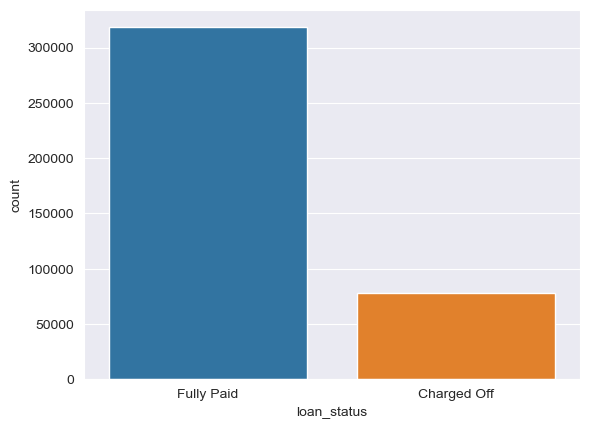

In [5]:
sns.countplot(x='loan_status',data=df)

C:\Users\danoz\AppData\Local\Temp\ipykernel_15816\2022642379.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['loan_amnt'],kde=False,bins=40)


(0.0, 45000.0)

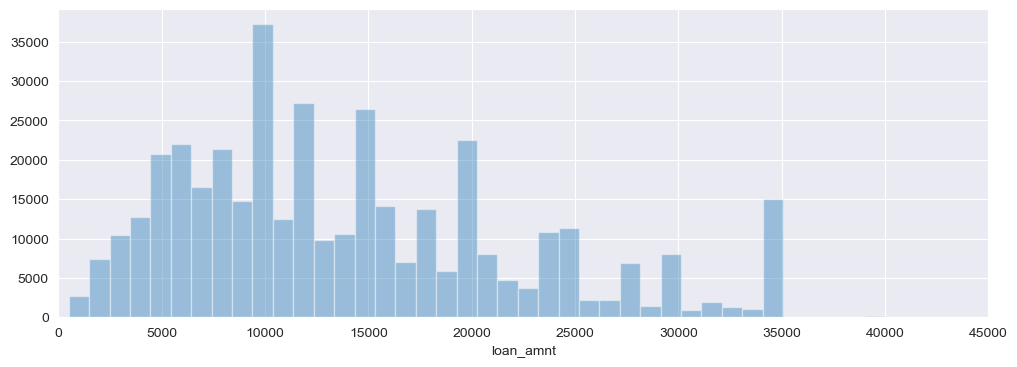

In [6]:
plt.figure(figsize=(12,4))
sns.distplot(df['loan_amnt'],kde=False,bins=40)
plt.xlim(0,45000)

C:\Users\danoz\AppData\Local\Temp\ipykernel_15816\4004689050.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True,cmap='viridis')


(10.0, 0.0)

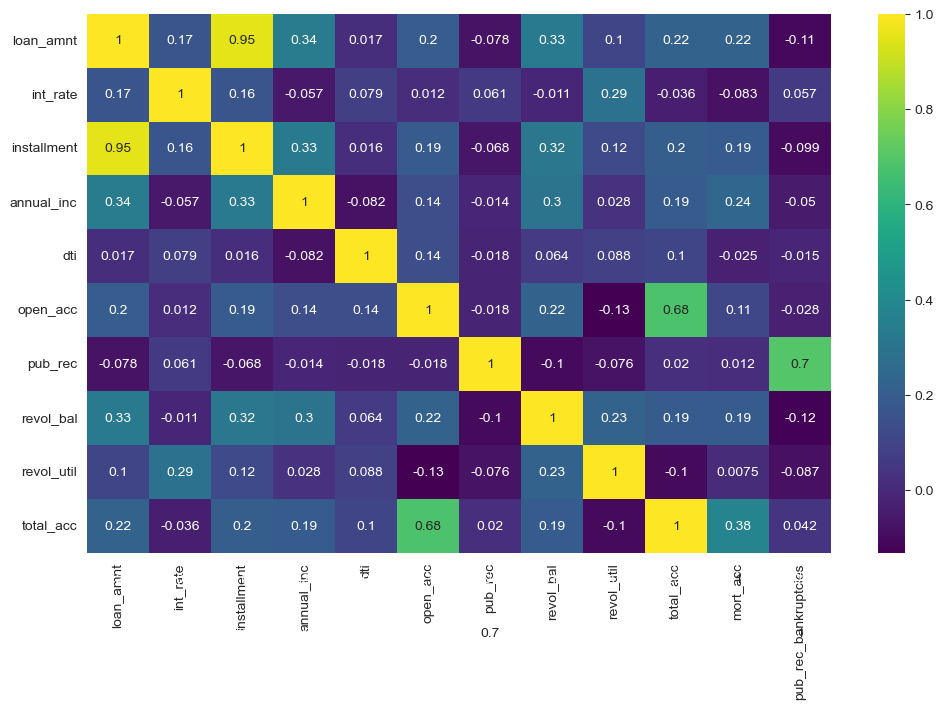

In [7]:
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(),annot=True,cmap='viridis')
plt.ylim(10, 0)

<AxesSubplot: xlabel='installment', ylabel='loan_amnt'>

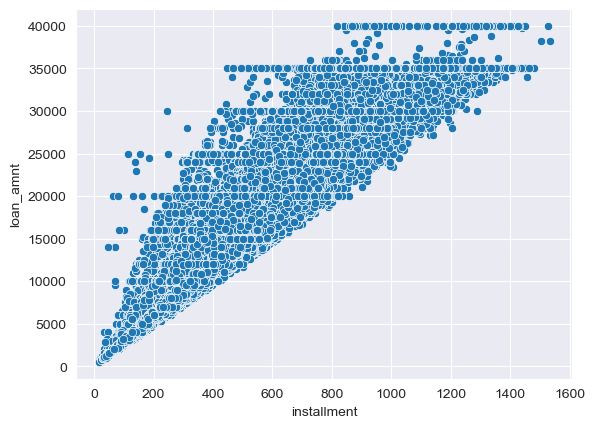

In [8]:
sns.scatterplot(x='installment',y='loan_amnt',data=df,)

<AxesSubplot: xlabel='sub_grade', ylabel='count'>

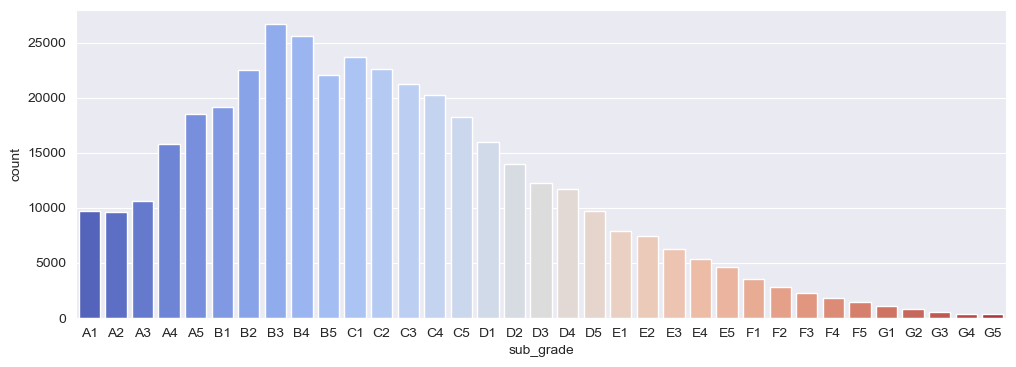

In [9]:
plt.figure(figsize=(12,4))
subgrade_order = sorted(df['sub_grade'].unique())
sns.countplot(x='sub_grade',data=df,order = subgrade_order,palette='coolwarm' )

In [10]:
df['loan_repaid'] = df['loan_status'].map({'Fully Paid':1,'Charged Off':0})

Let's do some preprocossing

In [11]:
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
loan_repaid                 0
dtype: int64

We gonna drop some useless columns.

In [12]:
df = df.drop('emp_title',axis=1)
df = df.drop('emp_length',axis=1)
df = df.drop('title',axis=1)


We will fill all Nan values inside the mort_acc column based on total_acc column(because of the highest correlation)

In [13]:
df.corr()['mort_acc'].sort_values()

C:\Users\danoz\AppData\Local\Temp\ipykernel_15816\2388834679.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()['mort_acc'].sort_values()


int_rate               -0.082583
dti                    -0.025439
revol_util              0.007514
pub_rec                 0.011552
pub_rec_bankruptcies    0.027239
loan_repaid             0.073111
open_acc                0.109205
installment             0.193694
revol_bal               0.194925
loan_amnt               0.222315
annual_inc              0.236320
total_acc               0.381072
mort_acc                1.000000
Name: mort_acc, dtype: float64

In [14]:
total_acc_avg = df.groupby('total_acc').mean()['mort_acc']
def fill_mort_acc(total_acc,mort_acc):

    if np.isnan(mort_acc):
        return total_acc_avg[total_acc]
    else:
        return mort_acc

df['mort_acc'] = df.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

C:\Users\danoz\AppData\Local\Temp\ipykernel_15816\2809669442.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_acc_avg = df.groupby('total_acc').mean()['mort_acc']


Next step - get some dummie variables

In [15]:
df['term'] = df['term'].apply(lambda term: int(term[:3]))
df = df.drop('grade',axis=1)

In [16]:
subgrade_dummies = pd.get_dummies(df['sub_grade'],drop_first=True)
df = pd.concat([df.drop('sub_grade',axis=1),subgrade_dummies],axis=1)

In [17]:
dummies = pd.get_dummies(df[['verification_status', 'application_type','initial_list_status','purpose' ]],drop_first=True)
df = df.drop(['verification_status', 'application_type','initial_list_status','purpose'],axis=1)
df = pd.concat([df,dummies],axis=1)

In [18]:
df['home_ownership']=df['home_ownership'].replace(['NONE', 'ANY'], 'OTHER')

dummies = pd.get_dummies(df['home_ownership'],drop_first=True)
df = df.drop('home_ownership',axis=1)
df = pd.concat([df,dummies],axis=1)

In [19]:
df['zip_code'] = df['address'].apply(lambda address:address[-5:])
dummies = pd.get_dummies(df['zip_code'],drop_first=True)
df = df.drop(['zip_code','address'],axis=1)
df = pd.concat([df,dummies],axis=1)

In [20]:
df = df.drop('issue_d',axis=1)

In [21]:
df['earliest_cr_year'] = df['earliest_cr_line'].apply(lambda date:int(date[-4:]))
df = df.drop('earliest_cr_line',axis=1)

Starting with test split and Sklearn

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
df = df.drop('loan_status',axis=1)
X = df.drop('loan_repaid',axis=1).values
y = df['loan_repaid'].values

Reduce the size of data

In [24]:
df = df.sample(frac=0.1,random_state=101)
print(len(df))

39603


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

Some normalisation

In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Create the model

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [29]:
model = Sequential()

# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw


# input layer
model.add(Dense(78,  activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(39, activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(19, activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=1,activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [30]:
model.fit(x=X_train,
          y=y_train,
          epochs=25,
          batch_size=256,
          validation_data=(X_test, y_test),
          )

Epoch 1/25
1238/1238 [==============================] - 8s 6ms/step - loss: 0.5071 - val_loss: 0.4943
Epoch 2/25
1238/1238 [==============================] - 7s 5ms/step - loss: 0.4984 - val_loss: 0.4942
Epoch 3/25
1238/1238 [==============================] - 7s 6ms/step - loss: 0.4973 - val_loss: 0.4944
Epoch 4/25
1238/1238 [==============================] - 7s 6ms/step - loss: 0.4966 - val_loss: 0.4947
Epoch 5/25
1238/1238 [==============================] - 7s 6ms/step - loss: 0.4961 - val_loss: 0.4943
Epoch 6/25
1238/1238 [==============================] - 7s 6ms/step - loss: 0.4958 - val_loss: 0.4943
Epoch 7/25
1238/1238 [==============================] - 6s 5ms/step - loss: 0.4956 - val_loss: 0.4943
Epoch 8/25
1238/1238 [==============================] - 7s 6ms/step - loss: 0.4955 - val_loss: 0.4943
Epoch 9/25
1238/1238 [==============================] - 7s 6ms/step - loss: 0.4954 - val_loss: 0.4943
Epoch 10/25
1238/1238 [==============================] - 7s 6ms/step - loss: 0.495

<AxesSubplot: >

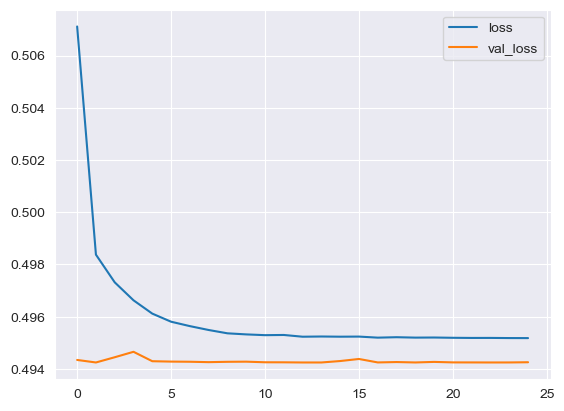

In [31]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

In [35]:
from sklearn.metrics import classification_report,confusion_matrix
pred = (model.predict(X_test) > 0.5).astype('int32')
print(classification_report(y_test,pred))

2476/2476 [==============================] - 5s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     15493
           1       0.80      1.00      0.89     63713

    accuracy                           0.80     79206
   macro avg       0.40      0.50      0.45     79206
weighted avg       0.65      0.80      0.72     79206



C:\Users\danoz\.conda\envs\conda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\danoz\.conda\envs\conda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\danoz\.conda\envs\conda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, pred))
print('\n')
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     15493
           1       0.80      1.00      0.89     63713

    accuracy                           0.80     79206
   macro avg       0.40      0.50      0.45     79206
weighted avg       0.65      0.80      0.72     79206



[[    0 15493]
 [    0 63713]]


C:\Users\danoz\.conda\envs\conda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\danoz\.conda\envs\conda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\danoz\.conda\envs\conda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
